# Bayesian State-Space Models for Weather Prediction

#### According to [MathWorks](https://www.mathworks.com/help/econ/bayesian-state-space-model.html#): "A Bayesian state-space model treats the state-space model parameters as random variables, rather than fixed but unknown quantities, with joint prior distribution. This treatment leads to a more flexible model and intuitive inferences."

##### In this project, the Global Historical Climatology Network (GHCN) daily dataset, specifically focusing on temperature data, was used to experiment with Bayesian state-space model for Weather Forecast.  

##### The GHCN dataset is maintained by the National Oceanic and Atmospheric Administration (NOAA) and contains daily climate records from thousands of weather stations worldwide.

* Data Source: NOAA GHCN daily dataset, available at [this link.](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/USW00094728.csv.gz)

* Station: For this example, the data used is from the New York, Central Park station (ID: USW00094728).

* Processing: Filtered to include only maximum daily temperatures (TMAX) resampled to monthly averages for analysis.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()
os.chdir('your-path')

In [ ]:
!pip install numpy pandas tensorflow keras tensorflow_probability

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [5]:
tfd = tfp.distributions
tfpl = tfp.layers
tfp_sts = tfp.sts

In [6]:
# Load and preprocess GHCN daily dataset:
url = "https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/USW00094728.csv.gz"  # Example station: New York, Central Park
weather_data = pd.read_csv(url, compression='gzip', header=None, names=['ID', 'DATE', 'ELEMENT', 'VALUE', 'MFLAG', 'QFLAG', 'SFLAG', 'OBS-TIME'])

<ipython-input-6-06632a865a5b>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(url, compression='gzip', header=None, names=['ID', 'DATE', 'ELEMENT', 'VALUE', 'MFLAG', 'QFLAG', 'SFLAG', 'OBS-TIME'])


In [7]:
# Filter for temperature data (TMAX) and preprocess
temperature_data = weather_data[weather_data['ELEMENT'] == 'TMAX'][['DATE', 'VALUE']]
temperature_data['DATE'] = pd.to_datetime(temperature_data['DATE'], format='%Y%m%d')


In [8]:
# Convert temperature from tenths of degrees Celsius to degrees Celsius
temperature_data['VALUE'] = temperature_data['VALUE'] / 10.0


In [9]:
# Display some sample data
print("Sample of the temperature data after filtering for TMAX:")
print(temperature_data.head())

Sample of the temperature data after filtering for TMAX:
        DATE  VALUE
0 1869-01-01   -1.7
1 1869-01-02   -2.8
2 1869-01-03    1.7
3 1869-01-04    2.8
4 1869-01-05    6.1


In [10]:
# Check for missing values and handle them if necessary
print(f"Missing values in temperature data: {temperature_data.isnull().sum()}")


Missing values in temperature data: DATE     0
VALUE    0
dtype: int64


In [11]:
# Validate the data range
print(f"Data range after outlier removal: {temperature_data['VALUE'].min()} to {temperature_data['VALUE'].max()}")


Data range after outlier removal: -16.7 to 41.1


In [12]:
# Resample data to monthly means
temperature_data.set_index('DATE', inplace=True)
monthly_data = temperature_data.resample('M').mean()

In [13]:
# Display the size and a sample of the resampled data
print(f"Size of resampled monthly data: {monthly_data.shape}")
print("Sample of the resampled monthly data:")
print(monthly_data.head())

Size of resampled monthly data: (1866, 1)
Sample of the resampled monthly data:
                VALUE
DATE                 
1869-01-31   4.174194
1869-02-28   4.282143
1869-03-31   5.470968
1869-04-30  13.093333
1869-05-31  19.375000


In [14]:
# Ensure there is enough data
if len(monthly_data) < 24:  # Minimum of 24 months to create a train/test split with 12 months input
    raise ValueError("Not enough data to split into training and testing sets.")


In [15]:
# Prepare the data for the model
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [16]:
# Prepare the dataset
time_step = 12  # Using 12 months (1 year) for prediction
data = monthly_data.values
X, y = create_dataset(data, time_step)

In [17]:
# Check the size of the dataset created
print(f"Dataset X shape: {X.shape}, y shape: {y.shape}")


Dataset X shape: (1853, 12), y shape: (1853,)


In [18]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [19]:
print(f"Train size: {train_size}, Test size: {len(X_test)}")

Train size: 1482, Test size: 371


In [32]:
# Define the Bayesian State-Space model
observed_time_series = monthly_data['VALUE'].values
date_range = pd.date_range(start=monthly_data.index[0], periods=len(observed_time_series), freq='M')


In [33]:
# Define the structural components of the model
trend = tfp_sts.LocalLinearTrend(observed_time_series=observed_time_series)
seasonal = tfp_sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)

In [34]:
# Combine into a single model
model = tfp_sts.Sum([trend, seasonal], observed_time_series=observed_time_series)


In [35]:
# Fit the model
variational_posteriors = tfp_sts.build_factored_surrogate_posterior(model=model)
optimizer = tf.optimizers.Adam(learning_rate=0.1)


In [36]:
# Evidence Lower Bound (ELBO): The ELBO is a lower bound on the marginal likelihood
# (also known as the evidence) of the observed data. In the context of variational inference, the ELBO is a crucial concept
# and serves as the objective function that we aim to maximize or equivalently, minimize its negative.
@tf.function
def train_step():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_distribution(observed_time_series).log_prob,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=1)
    return elbo_loss_curve

In [37]:
num_steps = 200
for step in range(num_steps):
    elbo_loss = train_step()
    if step % 10 == 0:  # Print the ELBO loss every 10 steps
        tf.print("Step:", step, "ELBO loss:", elbo_loss)

Step: 0 ELBO loss: [7454.9467804789574]
Step: 10 ELBO loss: [6060.9037169987814]
Step: 20 ELBO loss: [4709.8997349637384]
Step: 30 ELBO loss: [4369.46524530185]
Step: 40 ELBO loss: [4083.5516465816081]
Step: 50 ELBO loss: [4022.7708612388546]
Step: 60 ELBO loss: [3964.5024116183326]
Step: 70 ELBO loss: [3935.1849166099782]
Step: 80 ELBO loss: [3914.2083283279135]
Step: 90 ELBO loss: [3903.1828838551319]
Step: 100 ELBO loss: [3888.0555274465496]
Step: 110 ELBO loss: [3885.3418344805978]
Step: 120 ELBO loss: [3871.6048739918583]
Step: 130 ELBO loss: [3867.3703672852075]
Step: 140 ELBO loss: [3862.7661671912756]
Step: 150 ELBO loss: [3859.0384064751543]
Step: 160 ELBO loss: [3863.4356266462937]
Step: 170 ELBO loss: [3853.6465129037215]
Step: 180 ELBO loss: [3856.3393369605787]
Step: 190 ELBO loss: [3858.5688464624595]


In [38]:
# Sample from the posterior
posterior_samples = variational_posteriors.sample(50)

In [39]:
# Forecast future values
forecast_dist = tfp_sts.forecast(model, observed_time_series, posterior_samples, num_steps_forecast=12)


In [42]:
# Ensure forecast_mean and forecast_stddev are 1-dimensional
forecast_mean = forecast_dist.mean().numpy().flatten()
forecast_stddev = forecast_dist.stddev().numpy().flatten()

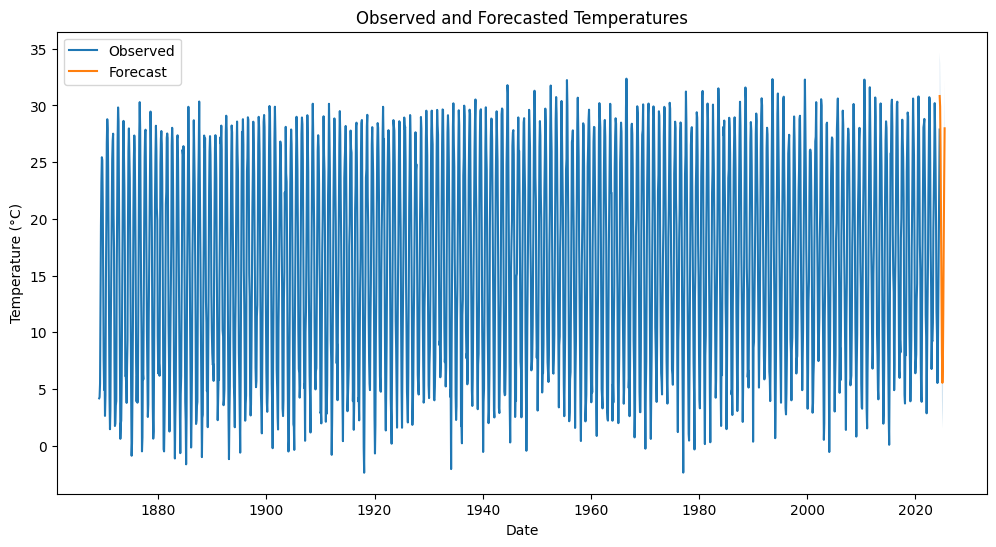

In [43]:
# Plot the results
plt.figure(figsize=(12, 6))
num_steps = len(observed_time_series)
plt.plot(date_range, observed_time_series, label='Observed')
forecast_range = pd.date_range(start=date_range[-1], periods=12, freq='M')
plt.plot(forecast_range, forecast_mean, label='Forecast')
plt.fill_between(forecast_range, forecast_mean - 2 * forecast_stddev, forecast_mean + 2 * forecast_stddev, alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Observed and Forecasted Temperatures')
plt.legend()
plt.show()

In [44]:
# Let's zoom the data in order to have better view of predicted future values:
# Define the zoom range
zoom_years = 10
end_date = date_range[-1]
start_date = end_date - pd.DateOffset(years=zoom_years)
zoom_data = monthly_data.loc[start_date:end_date]

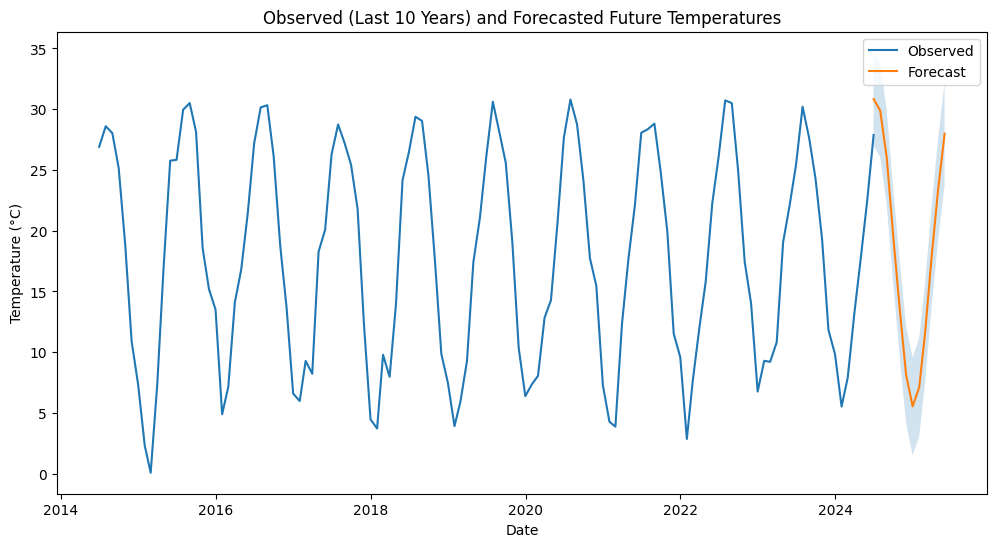

In [47]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(zoom_data.index, zoom_data['VALUE'], label='Observed')
forecast_range = pd.date_range(start=end_date, periods=12, freq='M')
plt.plot(forecast_range, forecast_mean, label='Forecast')
plt.fill_between(forecast_range, forecast_mean - 2 * forecast_stddev, forecast_mean + 2 * forecast_stddev, alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Observed (Last 10 Years) and Forecasted Future Temperatures')
plt.legend()
plt.show()